# Homework 5

Welcome to homework 5!  This week's homework is about sampling and estimating statistics from samples, plus some review of earlier material on expressions and tables.  You'll do the assignment by completing this notebook, filling in the cells provided. When you’re done:

1. Select `Run All` from the `Cell` menu to ensure that you have executed all cells, including the test cells.  Make sure that the visualizations you create are actually displayed.
2. Select `Download as PDF via LaTeX (.pdf)` from the `File` menu.  (Sometimes that seems to fail.  If it does, you can download as HTML, open the .html file in your browser, and print it to a PDF.)
3. Read that file! If any of your lines are too long and get cut off, we won't be able to see them,
   so break them up into multiple lines and download again.
4. Submit that downloaded file (called `hw05.pdf`) to Gradescope.

If you cannot submit online, come to office hours for assistance. The office hours
schedule appears on [data8.org/weekly](http://data8.org/weekly).

This assignment is due 5pm Tuesday, March 1. You will receive an early submission bonus point if you turn it in by 5pm Thursday, February 25. Directly sharing answers is not okay, but discussing problems with anyone is encouraged.

# 0. Preliminaries

As usual, **run the cell below** to prepare the lab and the automatic tests. **Passing the automatic tests does not guarantee full credit on any question.** The tests are provided to help catch some common errors, but it is *your* responsibility to answer the questions correctly.

In [19]:
# Run this cell, but please don't change it.

# These lines import the NumPy and datascience modules.
import numpy as np
# This way of importing the datascience module lets you write "Table" instead
# of "datascience.Table".  The "*" means "import everything in the module."
from datascience import *

# This line imports a very special module we made for this assignment.
from cats_and_boxes import *

# These lines set up visualizations.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

# These lines load the tests.
from client.api.assignment import load_assignment 
hw05 = load_assignment('hw05.ok')

Assignment: HW 05
OK, version v1.5.1



# 1. Climate and water
To get more practice analyzing data with tables, you'll work with a dataset about climate.  Theory says that land masses near large bodies of water have more moderate temperatures, since the water cools the land when it's hot and warms it when it's cold.  You'll be investigating whether that means places near coastlines have smaller daily temperature fluctuations than places far away from coastlines.

The US National Oceanic and Atmospheric Administration (NOAA) operates thousands of weather stations (mostly in the US) that collect information about local climate.  Among other things, each station records the highest and lowest observed temperature each day.  These data, called "Quality Controlled Local Climatological Data," are publicly available [here](http://www.ncdc.noaa.gov/orders/qclcd/) and described [here](https://www.ncdc.noaa.gov/data-access/land-based-station-data/land-based-datasets/quality-controlled-local-climatological-data-qclcd).

The dataset consists of 3 tables:
* The main dataset is a sample of all the daily readings from 2015.  (There were half a million total readings in the original dataset, but that takes some time to process, so we've sampled it for you.)  These are in a table called `daily_temp.csv`.  Each row corresponds to one day at one station, and includes the maximum and minimum temperature (in degrees Fahrenheit) for that day, the day (in MonthDay format), and an identifier, called a WBAN (Weather Bureau Army Navy) ID, for the station that made the reading.  When you read this into a Table, call it `daily_temp`.
* A separate table, called `stations.csv`, contains information about each station.  In particular, it gives the global coordinates (latitude and longitude) of each station, identified by WBAN ID.  Call this Table `stations`.  **Note:** `stations.csv` actually uses the pipe character ("`|`") to separate values, rather than commas.  To read it, use `Table.read_table("stations.csv", sep="|")` .
* A third table, called `coast_distance.csv`, tells us roughly how far away every place on Earth (to a precision of half a degree latitude/longitude) is from a coastline.  The data come from [a NASA project](http://oceancolor.gsfc.nasa.gov/DOCS/DistFromCoast/).  Call this table `coast_distance`.

You will notice that some values are `nan`, which stands for *not a number*. These are values that are missing from the table for some reason. We will not use the columns that have missing values.

**Question 1.1.** Use the next cell to load the tables.

In [20]:
# Load the 3 tables described above.  Read the note about the special
# format of stations.csv.
daily_temp = Table.read_table("daily_temp.csv") #SOLUTION
stations = Table.read_table("stations.csv", sep="|") #SOLUTION
coast_distance = Table.read_table("coast_distance.csv") #SOLUTION
daily_temp.show(3)
stations.show(3)
coast_distance.show(3)

WBAN,Tmax,Tmin,MonthDay
93997,25,13,222
14938,87,69,902
3953,89,67,818


WBAN,WMO,CallSign,ClimateDivisionCode,ClimateDivisionStateCode,ClimateDivisionStationCode,Name,State,Location,Latitude,Longitude,GroundHeight,StationHeight,Barometer,TimeZone
100,nan,M89,nan,3,nan,ARKADELPHIA,AR,DEXTER B FLORENCE MEM FLD AP,34.0997,-93.0658,182,nan,nan,-6
101,nan,KQHT,nan,nan,nan,BISHKEK,nan,MANAS INTERNATIONAL AIRPORT,43.067,74.483,2090,nan,nan,6
102,nan,IAN,nan,50,nan,KIANA,AK,BOB BARKER MEMORIAL AIRPORT,66.983,-160.433,168,nan,nan,-9


longitude,latitude,distance to coast (km)
-180,89.5,758.044
-179.5,89.5,757.797
-179,89.5,757.526


In [21]:
_ = hw05.grade('q11')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 4
    Failed: 0
[ooooooooook] 100.0% passed



**Question 1.2.** Choose an appropriate visualization to display the distribution of maximum temperatures across all the daily readings *and* the distribution of minimum temperatures across all the daily readings.  Write code that displays both in the same graph.

*Hint:* The visualization methods you've seen allow you to display two columns in one chart by passing a list of labels as the data argument. For example, if `t` is a table and `"a"` and `"b"` are two of its columns, then `t.hist(["a", "b"])` makes histograms of both columns in one graph.  Similarly, if `t` is a table, `"c"` is a column of categories, and `"d"` and `"e"` are columns of counts, then `t.barh("c", ["d", "e"])` makes bar charts of the counts of `"d"` and `"e"`.

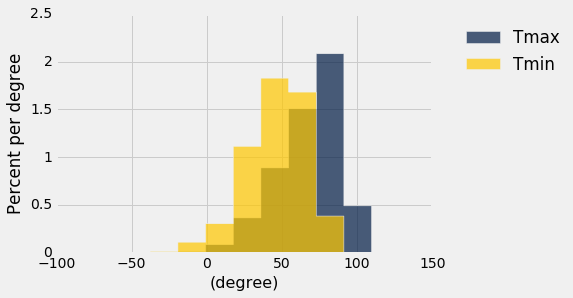

In [22]:
# Display the distributions of maximum and minimum temperatures.
# Use just one graph.
daily_temp.hist(["Tmax", "Tmin"], unit='degree') #SOLUTION

**Question 1.3.** The temperature spread for a day at a station is the difference between the maximum temperature and minimum temperature at that station for that day.  Make a visualization to display the distribution of temperature spreads for each day.

*Hint:* First construct a new column called `spread`, then visualize it.

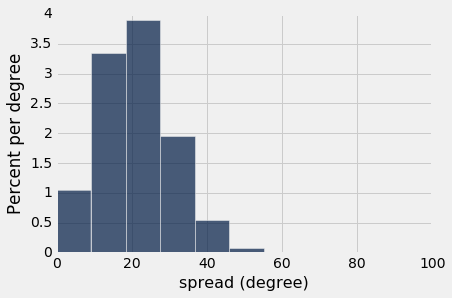

In [23]:
# Display the distribution of daily temperature spreads.
daily_temp.with_column("spread", daily_temp.column(1) - daily_temp.column(2)).hist("spread", unit='degree') #SOLUTION

Below is another cell to help you visualize the data in the `stations` table.  For each station, it plots a single point, which is that station's latitude/longitude coordinates.  Just run it.  What does it look like?  Can you tell where most of the NOAA stations are located in the world?

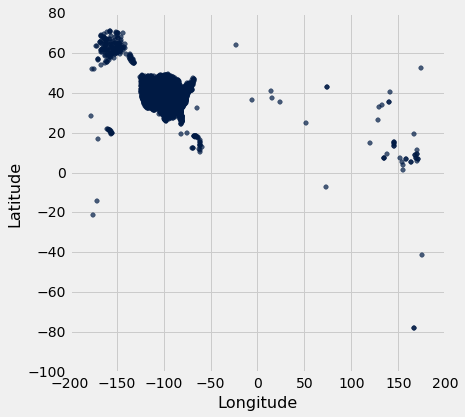

In [24]:
# Run this cell and try to interpret the scatter diagram it generates.
stations.scatter("Longitude", "Latitude")

Now we're going to see how temperature spread relates to distance from the coast.  `daily_temp` tells us which station each reading came from, but not the distance of that station from a coastline.   `stations` tells us where each station is in the world, but not how far it is from a coastline.  `coast_distance` tells us how far each place in the world is from a coastline.  So this analysis will involve all 3 tables, and it will involve `join`ing them together.  We'll guide you through the steps.

First, we want to build a table called `stations_with_distances` that has the WBAN and distance-to-coast for each station in the `stations` table.  We'll do that over the course of the next few questions.

**Question 1.4.** Look at the first row of the `stations` table, which describes the station at Dexter B. Florence Memorial Field Airport, in the US state of Arkansas.  If you [look it up on a map](http://www.mapdevelopers.com/distance_finder.php?&points=%5B%5B29.80251790576448%2C-93.22998046875%5D%2C%5B34.09865686549439%2C-93.06673049926758%5D%5D), you'll see that this station is about 480 kilometers from the nearest coastline to the South in Louisiana.

Find the (approximate) distance-to-coast for this station, looking at the `coast_distance` table manually.  (Instead of looking through the whole table, you might want to use Python code to narrow your search.)  What is that distance?  *More importantly,* how did you find it?

*Write your answer here, replacing this text.*

In [25]:
# Here's a cell for working on Question 1.4, but only the answer above will be scored.
coast_distance.where(np.logical_and(coast_distance.column('latitude') == 34, coast_distance.column('longitude') == -93, ))

longitude,latitude,distance to coast (km)
-93,34,452.515


We're going to use `join` to get Python to perform that process for every station.  Here are two observations that pose obstacles to using `join`:
1. The latitudes and longitudes in `coast_distance` are only given to half a degree of precision.  For example, that means there is an entry for (-20, 45.5) (that is, -20 degrees latitude and 45.5 degrees longitude), but not for (-20, 45.6) or (-19.9, 45.5).  By contrast, the latitudes and longitudes in `stations` are given to a precision of ten-thousandths of a degree.  For example, Dexter B. Florence Memorial Field Airport is at (34.0997, -93.0658).
2. We have to match each station in `stations` to a row in `coast_distance` that matches both its latitude *and* its longitude.

**Question 1.5.** Why is the first observation an obstacle for `join`ing `stations` with `coast_distance`?

*Write your answer here, replacing this text.*

**Question 1.6.** Why is the second observation an obstacle for `join`ing `stations` with `coast_distance`?

*Write your answer here, replacing this text.*

Here is how we'll fix these problems:
1. We'll round off the coordinates in `stations` to the nearest half-degree.  That way, each station's rounded-off location will exactly match a location in `coast_distance`.  For example, we'll round Dexter B. Florence Memorial Field Airport's coordinates to (34, -93), which exactly matches the coordinates of row 80094 in `coast_distance`.  Hopefully that's the row you matched it to manually in question 1.4!
2. Then we'll make a single column called `"lat,long"` in both `stations` and `coast_distance` that combines each row's latitude and longitude into a single string.  We'll write functions to do these steps for one entry in our tables, and then we'll use `apply` to fix all the data at once.

(*Note:* You might worry that rounding the stations' coordinates will change their distance-to-coast.  They will be off by a little bit, but that's okay.  For an extra challenge, try to figure out how much error we might be introducing.)

**Question 1.7.** The following function is useful for one of the two steps.  Its argument is a single number, and it returns a number.  Describe what it does. If you're not sure, try calling it on various numbers such as 3, 3.1415, and 0.31415.

*Hint:* Remember that `round` rounds a number to the nearest integer.

In [26]:
def mysterious_function(num):
    return round(2 * num) / 2

*Describe what `mysterious_function` does, replacing this text.*

**Question 1.8.** Write a function called `append_numbers` that takes two numbers as its arguments and returns the string `"<first number>,<second number>"`.  For example, the value of `append_numbers(1.5, -2.0)` should be the string `"1.5,-2.0"`.  (We're just using double-quotes to delimit the string; the return value of `append_numbers` shouldn't include any actual quote characters.  Also, note the comma in between the numbers.)

*Hint 1:* Remember the `str` function, which converts a number to a string that looks like that number.

*Hint 2:* Adding two or more strings together with `+` appends them together.  For example, `"port" + "able"` is `"portable"`.

In [27]:
def append_numbers(num1, num2):
    return str(num1) + "," + str(num2) # SOLUTION

In [28]:
_ = hw05.grade('q18')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



**Question 1.9.** Create two new columns from `stations` called `Rounded Latitude` and `Rounded Longitude`, the result of rounding each latitude and longitude in `stations`, respectively.  Extend `stations` with these columns, calling the resulting table `stations_rounded`.

In [29]:
stations_rounded = stations.with_columns([
        "Rounded Latitude", 
        stations.apply(mysterious_function, "Latitude"), # SOLUTION
        "Rounded Longitude", 
        stations.apply(mysterious_function, "Longitude") # SOLUTION
    ])
stations_rounded

WBAN,WMO,CallSign,ClimateDivisionCode,ClimateDivisionStateCode,ClimateDivisionStationCode,Name,State,Location,Latitude,Longitude,GroundHeight,StationHeight,Barometer,TimeZone,Rounded Latitude,Rounded Longitude
100,nan,M89,nan,3,nan,ARKADELPHIA,AR,DEXTER B FLORENCE MEM FLD AP,34.0997,-93.0658,182,nan,nan,-6,34,-93
101,nan,KQHT,nan,nan,nan,BISHKEK,nan,MANAS INTERNATIONAL AIRPORT,43.067,74.483,2090,nan,nan,6,43,74.5
102,nan,IAN,nan,50,nan,KIANA,AK,BOB BARKER MEMORIAL AIRPORT,66.983,-160.433,168,nan,nan,-9,67,-160.5
103,nan,IWK,nan,50,nan,WALES,AK,WALES AIRPORT,65.617,-168.1,23,nan,nan,-9,65.5,-168
104,nan,FSP,nan,50,nan,NIKOLAI,AK,NIKOLAI AIRPORT,63.017,-154.367,414,nan,nan,-9,63,-154.5
105,nan,MDM,nan,50,nan,MARSHALL,AK,MARSHALL DON HUNTER SR AIRPORT,61.867,-162.033,102,nan,nan,-9,62,-162
106,nan,IIK,nan,50,nan,AKIAK,AK,KIPNUK AIRPORT,60.9,-161.233,30,nan,nan,-9,61,-161
107,nan,KNW,nan,50,nan,NEW STUYAHOK,AK,NEW STUYAHOK AIRPORT,59.45,-157.333,302,nan,nan,-9,59.5,-157.5
108,nan,SCM,nan,50,nan,SCAMMON BAY,AK,SCAMMON BAY AIRPORT,61.85,-165.567,14,nan,nan,-9,62,-165.5
109,nan,MBA,nan,50,nan,MANOKOTAK,AK,MANOKOTAK AIRPORT,58.983,-159.05,52,nan,nan,-9,59,-159


In [30]:
_ = hw05.grade('q19')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



**Question 1.10.** Create a new column from `stations_rounded` called `lat,long` that is the result of appending the rounded latitudes and longitudes with `append_numbers`.  Extend `stations_rounded` with this column.  Do the same for the latitudes and longitudes in `coast_distance`.

*Hint:* `apply` can combine two or more columns by saying, for example, `my_table.apply(two_arg_function, ["a_column", "another_column"])`.  That will return a single array, which is the result of applying `two_arg_function` to each pair of elements in the columns `"a_column"` and `"another_column"`.

*Hint 2:* Be careful about capitalization of labels. The labels `"Latitude"` and `"latitude"` both appear in different tables.

In [31]:
# Make this the column you want to add to stations_rounded (that is,
# an array of "<latitude>,<longitude>" strings.  The line of code after
# this one will add it to stations_rounded for you.
stations_rounded_lat_long = stations_rounded.apply(append_numbers, ["Rounded Latitude", "Rounded Longitude"]) # SOLUTION
stations_rounded.append_column("lat,long", stations_rounded_lat_long) # Adds a column to stations_rounded
# Make this the column you want to add to coast_distance (that is,
# an array of "<latitude>,<longitude>" strings.  The line of code
# after this one will add it to coast_distance for you.
coast_distance_lat_long = coast_distance.apply(append_numbers, ["latitude", "longitude"]) # SOLUTION
coast_distance.append_column("lat,long", coast_distance_lat_long)     # Adds a column to coast_distance

In [32]:
_ = hw05.grade('q110')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



**Question 1.11.** Now we're ready to join!  Create a new table called `stations_with_distances` that extends `stations_rounded` with a column of distances to the nearest coastline.  That column should be called `"distance to coast (km)"`.  Use `join`. The result will take a minute to compute.

In [33]:
stations_with_distances = stations_rounded.join("lat,long", coast_distance) # SOLUTION
stations_with_distances

"lat,long",WBAN,WMO,CallSign,ClimateDivisionCode,ClimateDivisionStateCode,ClimateDivisionStationCode,Name,State,Location,Latitude,Longitude,GroundHeight,StationHeight,Barometer,TimeZone,Rounded Latitude,Rounded Longitude,longitude,latitude,distance to coast (km)
"-14.5,-170.5",61705,91765,NSTU,2,91,4690,PAGO PAGO,AS,TAFUNA/PAGO PAGO INTERNATIONAL AP,-14.3306,-170.714,12,10,15,-11,-14.5,-170.5,-170.5,-14.5,24.8429
"-21.0,-175.0",487,nan,NFTF,nan,nan,nan,FUA AMOTU,nan,FUA AMOTU TONGA,-21.23,-175.15,125,nan,nan,13,-21,-175,-175,-21,14.5065
"-41.5,175.0",488,nan,NZWN,nan,nan,nan,WELLINGTON,nan,WELLINGTON INTL,-41.3,174.8,23,nan,nan,12,-41.5,175,175,-41.5,10.2087
"-7.5,72.5",70701,61967,NKW,nan,nan,nan,DIEGO GARCIA,nan,DIEGO GARCIA NAVAL AIR STATION,-7.3,72.4,14,9,13,6,-7.5,72.5,72.5,-7.5,9.69319
"-78.0,166.5",414,nan,NZPG,nan,nan,nan,PEGASUS FIELD,nan,PEGASUS FIELD,-77.95,166.517,17,nan,nan,11,-78,166.5,166.5,-78,12.4332
"-78.0,166.5",87601,nan,NZCM,nan,nan,nan,MCMURDO SOUND,nan,NSFA MCMURDO SOUND,-77.8833,166.733,79,110,112,0,-78,166.5,166.5,-78,12.4332
"1.0,155.0",40507,91434,nan,4,91,4325,nan,FM,KAPINGAMARANGI,1.08333,154.8,9,nan,nan,11,1,155,155,1,24.6467
"10.5,-61.5",11634,78970,TTPP,nan,nan,nan,PIARCO,nan,PIARCO INTL AP,10.5833,-61.35,40,nan,nan,4,10.5,-61.5,-61.5,10.5,2.29569
"11.0,-61.0",410,nan,TTCP,nan,nan,nan,BON ACCORD VILLAGE,nan,ARTHUR NAPOLEON RAYMOND ROBINSON INTERNATIONAL AIRPORT,11.15,-60.833,40,nan,nan,-4,11,-61,-61,11,19.875
"11.0,170.0",nan,91258,nan,4,91,4895,nan,MH,UTIRIK,11.2333,169.85,6,nan,nan,12,11,170,170,11,28.804


In [34]:
_ = hw05.grade('q111')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



**Question 1.12.** Now we're going to join again to get the station information for each daily reading.  This time it's much easier!  Create a new table called `daily_temp_with_distances` that extends `daily_temp` with a column of distances to the nearest coastline, called `"distance to coast (km)"`.  Use `join` again.

*Hint:* What column of identifiers do `daily_temp` and `stations_with_distances` share?

In [35]:
daily_temp_with_distances = daily_temp.join("WBAN", stations_with_distances) # SOLUTION
daily_temp_with_distances

WBAN,Tmax,Tmin,MonthDay,"lat,long",WMO,CallSign,ClimateDivisionCode,ClimateDivisionStateCode,ClimateDivisionStationCode,Name,State,Location,Latitude,Longitude,GroundHeight,StationHeight,Barometer,TimeZone,Rounded Latitude,Rounded Longitude,longitude,latitude,distance to coast (km)
130,101,78,905,"29.0,-98.5",nan,PEZ,nan,41,nan,PLEASANTON,TX,PLEASANTON MUNICIPAL AIRPORT,28.95,-98.517,430,nan,nan,-6,29,-98.5,-98.5,29,158.81
130,101,76,822,"29.0,-98.5",nan,PEZ,nan,41,nan,PLEASANTON,TX,PLEASANTON MUNICIPAL AIRPORT,28.95,-98.517,430,nan,nan,-6,29,-98.5,-98.5,29,158.81
130,51,35,305,"29.0,-98.5",nan,PEZ,nan,41,nan,PLEASANTON,TX,PLEASANTON MUNICIPAL AIRPORT,28.95,-98.517,430,nan,nan,-6,29,-98.5,-98.5,29,158.81
130,99,73,721,"29.0,-98.5",nan,PEZ,nan,41,nan,PLEASANTON,TX,PLEASANTON MUNICIPAL AIRPORT,28.95,-98.517,430,nan,nan,-6,29,-98.5,-98.5,29,158.81
130,63,52,121,"29.0,-98.5",nan,PEZ,nan,41,nan,PLEASANTON,TX,PLEASANTON MUNICIPAL AIRPORT,28.95,-98.517,430,nan,nan,-6,29,-98.5,-98.5,29,158.81
130,101,72,730,"29.0,-98.5",nan,PEZ,nan,41,nan,PLEASANTON,TX,PLEASANTON MUNICIPAL AIRPORT,28.95,-98.517,430,nan,nan,-6,29,-98.5,-98.5,29,158.81
130,88,63,427,"29.0,-98.5",nan,PEZ,nan,41,nan,PLEASANTON,TX,PLEASANTON MUNICIPAL AIRPORT,28.95,-98.517,430,nan,nan,-6,29,-98.5,-98.5,29,158.81
130,52,45,205,"29.0,-98.5",nan,PEZ,nan,41,nan,PLEASANTON,TX,PLEASANTON MUNICIPAL AIRPORT,28.95,-98.517,430,nan,nan,-6,29,-98.5,-98.5,29,158.81
130,79,67,515,"29.0,-98.5",nan,PEZ,nan,41,nan,PLEASANTON,TX,PLEASANTON MUNICIPAL AIRPORT,28.95,-98.517,430,nan,nan,-6,29,-98.5,-98.5,29,158.81
130,86,56,503,"29.0,-98.5",nan,PEZ,nan,41,nan,PLEASANTON,TX,PLEASANTON MUNICIPAL AIRPORT,28.95,-98.517,430,nan,nan,-6,29,-98.5,-98.5,29,158.81


In [36]:
_ = hw05.grade('q112')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



**Question 1.13.** Whew!  Now let's do the actual analysis we set out to do.  Compute the average temperature spread for stations that are more than 50 kilometers from a coastline and for those closer to a coastline.  Do this by computing a table called `spread_for_coastal_and_noncoastal` that looks like this **(except that these aren't the right numbers)**:

    >50km from coast | spread (°F) average
    False            | 0.1234
    True             | 5.6789

*Hint:* First, for each daily reading, compute two new columns: (1) the temperature spread, and (2) a boolean value that's True if that reading comes from a station that's more than 50km from the coast.  Elementwise arithmetic and comparison operators will be useful.  Then use `group` to produce the table we've asked for.

In [37]:
# Compute the table spread_for_coastal_and_noncoastal as described above.
# Our solution uses a single statement spread across a few lines, but
# feel free to compute the table however you like.
spread_for_coastal_and_noncoastal = Table().with_columns([
        "spread (°F)", 
        daily_temp_with_distances.column("Tmax") - daily_temp_with_distances.column("Tmin"), # SOLUTION
        ">50km from coast", 
        daily_temp_with_distances.column("distance to coast (km)") > 50 # SOLUTION
    ]).group(">50km from coast", np.average)
spread_for_coastal_and_noncoastal

>50km from coast,spread (°F) average
False,16.9441
True,22.7034


In [ ]:
_ = hw05.grade('q113')

If you're curious, you can run the following cell to see a scatter plot of temperature spreads versus distance to coast.  We've grouped the data by station to make the graph clearer.

In [ ]:
# Just run this cell to see a plot of the temperature spreads.
daily_temp_with_distances.with_column("spread", daily_temp_with_distances.column("Tmax") - daily_temp_with_distances.column("Tmin")) \
                         .group("WBAN", np.average) \
                         .select(["distance to coast (km) average", "spread average"]) \
                         .relabeled("distance to coast (km) average", "distance to coast (km)") \
                         .relabeled("spread average", "yearly average temperature spread (°F)") \
                         .scatter("distance to coast (km)")

# 2. Cats and boxes
Suppose we introduce two new types of Python objects: Boxes and Cats.  These are types of things in the same way that integers, strings, and functions are types of things.
* A Box is like a list -- it can contain any number of other objects, including other Boxes.  The things in a box are ordered from left to right.  To create a Box of things, call the function `Box` with each thing as an argument.  For example, `Box(1, 5, "some text")` is a Box containing, in order from left to right, the numbers 1 and 5 and the string "some text".
* A Cat is fluffy and devious and contains nothing.  To create a Cat, call the function `Cat` with no arguments.  The value of `Cat()` is a Cat object.

For each of the following pictures, create a Python representation of the box displayed in the picture, along with its contents (if any).  **For example**, the Python representation of a picture of an empty box is `Box()`.  Ignore any amusing (or unamusing) captions.

**Question 2.1.** <img src="cat01.jpg">

In [ ]:
# Set box_21 to the representation of the image above.
box_21 = Box(Cat()) #SOLUTION
box_21

In [ ]:
_ = hw05.grade("q21")

**Question 2.2.** <img src="cat02.jpg">

In [ ]:
# Set box_22 to the representation of the image above.
box_22 = Box(Cat(), Cat(), Cat(), Cat()) #SOLUTION
box_22

In [ ]:
_ = hw05.grade("q22")

**Question 2.3.** <img src="cat03.jpg">

In [ ]:
# Set box_23 to the representation of the image above.
box_23 = Box(Box(Box(Cat()))) #SOLUTION
box_23

In [ ]:
_ = hw05.grade("q23")

**Question 2.4.** <img src="cat04.jpg">

In [ ]:
# Set box_24 to the representation of the image above.
box_24 = Box(Cat(), Box(Cat())) #SOLUTION
box_24

In [ ]:
_ = hw05.grade("q24")

# 3. Warplanes

In this problem, we'll work through the number-of-warplanes estimation problem you saw in lecture.

Recall the setup: The British Royal Air Force (RAF) want to know how many warplanes the Germans have.  They hypothesize that the Germans label their planes with serial numbers, starting from 1 for the first plane, and increasing by 1 for each new plane built.  That means that the number of planes the Germans have is equal to the largest serial number among their planes.  Let's call that number `N`.

The RAF make the further assumption that each time the Germans send a plane into combat, they send one of their planes chosen uniformly at random, and an RAF observer always reports its serial number.  (That's not really true, and it's not exactly what the RAF assumed, but it makes the math simpler for this example.)  Some planes might be observed several times, or not at all.  So if the Germans have 5 planes and send planes into combat 3 times, the RAF might observe the serial numbers 4, 1, and 4.

Given a bunch of these random observations of serial numbers, the RAF want to estimate `N`.

We're going to simulate that sampling process and try out a few methods for estimating `N`.  Then we'll check how well each method typically does at estimating `N`.

**Question 3.1.** Suppose that `N` is actually 120 (though the RAF don't know that) and we observe serial numbers 14 times.
1. Write a function called `simulate_observations` to simulate that by making an array of 14 random serial numbers.  Your function should take no arguments and return the random array it generates.  Follow the random observation process described above.
2. **Then**, set `observations` to the result of one call to `simulate_observations`.

*Hint:* Remember the function `np.random.randint`.  The documentation is [here](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.random.randint.html); again, the examples at the end of the documentation are probably more useful than the other text.  If you prefer, you can use the `sample` method of an appropriately-constructed Table instead.

In [ ]:
# The biggest serial number.
N = 120
# The number of observations.
num_observations = 14

def simulate_observations():
    # Fill in this function.  It should return an array of 14 random
    # serial numbers, generated according to the random process
    # described above.
    return np.random.randint(1, N+1, num_observations) #SOLUTION

# Set observations to a random sample of 14 serial numbers
# by calling your function once.
observations = simulate_observations() #SOLUTION
observations

In [ ]:
_ = hw05.grade("q31")

**Question 3.2.** Draw a probability histogram to display the *distribution* of serial numbers from which each single serial number is sampled. 

*Hint 1:* You'll need to construct an appropriate table.

*Hint 2:* There is nothing random in the answer to this question.

In [ ]:
# Make your visualization here.
Table().with_column("serial number", np.arange(1, N+1)).hist(bins=np.arange(1, N+2)) #SOLUTION

**Question 3.3.** A straightforward way to estimate the biggest serial number is to find the biggest serial number among the serial numbers we observe.  Use that method to estimate `N` from `observations`.  Give your estimate the name `max_estimate`.

In [ ]:
# Set max_estimate to the biggest serial number among the
# observed serial numbers that you simulated in question 3.1.
max_estimate = max(observations)
max_estimate

In [ ]:
_ = hw05.grade('q33')

Here's another idea that comes from looking at the histogram in question 3.2.  If we observe a bunch of numbers uniformly distributed between 1 and `N`, then the average of those observations is likely to be the middle of the numbers, which is roughly $\frac{\texttt{N}}{2}$.  So if we multiply the average of our observations by 2, we might get something close to `N`.  If you prefer symbols, here's another way to say that:

$$\texttt{average}(\texttt{observations}) \approx \frac{\texttt{N}}{2} \\
  \implies 2 \times \texttt{average}(\texttt{observations}) \approx \texttt{N}$$

**Question 3.4.** Write a function called `mean_based_estimator` that takes a single argument, an array of observed serial numbers.  It should return the *mean* (a.k.a. the average) of the numbers in that array, times two.

*Remember*, the big-picture idea is that calling this function on an array of serial number observations (such as the array `observations`, but possibly other arrays) gives us an estimate of `N` based on those observations.  Your function should be just as happy to compute twice the mean of *any* array of numbers, though.

In [ ]:
def mean_based_estimator(nums):
    # Fill in this function as described above.
    return 2*np.average(nums) #SOLUTION
mean_based_estimator(np.array([4, 1, 4, 2])) # Should be (4+1+4+2)/4*2 = 5.5

In [ ]:
_ = hw05.grade('q34')

**Question 3.5.** Is the way of estimating `N` in question 3.4 actually different from the one in question 3.3?  Or does it always produce the same result?

*Write your answer in here, replacing this text.*

**Question 3.6.** Use `mean_based_estimator` to estimate `N` from `observations`.  Call the result `mean_based_estimate`.

In [ ]:
# Compute mean_based_estimate using your simulated observations
# from question 3.1 and the function you just defined in question 3.4.
mean_based_estimate = mean_based_estimator(observations) #SOLUTION
mean_based_estimate

In [ ]:
_ = hw05.grade('q36')

Either `max_estimate` or `mean_based_estimate` could be closer to the actual value of `N`, depending on how your observations turned out.  Rather than comparing them, it's more interesting to compare what would happen if we reproduced our 14 observations many times.

**Question 3.7.** Create a table called `estimates` with two columns named `"max_estimate"` and `"mean_based_estimate"`.  Using a `for` loop (or some other way, if you prefer), simulate the following process **1,000** times:
1. Generate a new set of 14 observations, in the same way you did for question 3.1.  (Can you reuse the `simulate_observations` function?)
2. Estimate `N` using the maximum of the observations.
3. Estimate `N` using your `mean_based_estimator` function.
4. Append the two estimates to your `estimates` table.

*Hint:* If you use a `for` loop, use the `with_row` method of `estimates` (which is documented [here](http://datascience.readthedocs.org/en/master/_autosummary/datascience.tables.Table.with_row.html#datascience.tables.Table.with_row)) in step 4.  You'll have to start out with a version of `estimates` with the two columns `"max_estimate"` and `"mean_based_estimate"`.

In [ ]:
# Make estimates a table of estimates of N based on 1000 simulated
# datasets of 14 observations.  You can use the code we've outlined
# here, or scrap it if you prefer.
estimates = Table(["max_estimate", "mean_based_estimate"])
for simulation_idx in range(1000): #SOLUTION
    new_observations = simulate_observations() #SOLUTION
    estimates.append([max(new_observations), mean_based_estimator(new_observations)]) #SOLUTION
estimates

In [ ]:
_ = hw05.grade("q37")

Consider the following visualization, which is based on the estimates of `N` you just generated:

In [ ]:
# Just run this cell.
estimates.hist(bins=np.arange(0, 160, 1))

**Question 3.8.** What do the blue and yellow histograms represent?  Your answer should look something like this: 

**"The blue histogram is the `___________` histogram of `_________`. The yellow histogram is the `____________` histogram of `__________`."**

*Hint*: You've learned a very specific term for these histograms.

*Write your answer here, replacing this text.*

**Question 3.9.** Why do the `max`-based estimates top out at 120, while some of the `mean`-based estimates are bigger than that?

*Write your answer here, replacing this text.*

**Question 3.10 [Optional].** The max and twice-the-mean estimators are two ways to estimate `N`, but there are other good ones.  Can you find something cleverer?  Come up with your own and investigate it.  Recreate the steps we went through for the other estimators:
1. Write a function (in the style of `max` and `mean_based_estimator`) to compute your estimate on a sample.
2. Compute your estimate on `observations`.
3. Compute a table of estimates using the max, twice-the-mean, and your own estimator, as in question 3.7.
4. Make a visualization like the histogram above, now displaying all 3 kinds of estimates in one graph.
5. Write up your conclusions, briefly.  Does it look like your estimator produces less-biased or less-variable estimates for this problem than the other 2?

This question *won't be graded*, but working on it will help you learn about estimators.

In [ ]:
# Use this cell for your analysis.

*Write your conclusions here, replacing this text.*

In [ ]:
# For your convenience, you can run this cell to run all the tests at once!
import os
_ = [hw05.grade(q[:-3]) for q in os.listdir("tests") if q.startswith('q')]